# DSE 210 Final - Question 4
## Text Classification Using Bernoulli Naive Bayes

In this workbook, we are using Bernoulli Naive Bayes to classify news group documents into one of 20 newsgroups.  Data is from the 20 Newsgroups data set, which is available at http://qwone.com/~jason/20Newsgroups/.

This workbook includes the following sections:
* Download and Read Data
* Preprocess Data
* Create Classifier Using Training Data
* Evaluate Performance on Test Data
* Visualizing Error by Plotting Confusion Matrix

Note that code for plotting confusion matrices was modified from example code found at http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html.

In [1]:
%matplotlib inline

In [2]:
# import packages
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

## Download and Read Data

In [3]:
!pwd

/Users/joshwilson/Documents/DSE/jsw037/DSE210


In [4]:
# create and move to 'data' directory
!mkdir 'NBdata'
%cd NBdata

/Users/joshwilson/Documents/DSE/jsw037/DSE210/NBdata


In [5]:
# get the '20news-bydate.tar.gz' data
!curl http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz -o '20news-bydate.tar.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.7M  100 13.7M    0     0  1920k      0  0:00:07  0:00:07 --:--:-- 1792k


In [6]:
# uncompress the '20news-bydate.tar.gz' data
!tar zxf 20news-bydate.tar.gz

In [7]:
# get the '20news-bydate-matlab.tgz' data
!curl http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz -o '20news-bydate-matlab.tgz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7398k  100 7398k    0     0  1804k      0  0:00:04  0:00:04 --:--:-- 1806k


In [8]:
# uncompress the '20news-bydate-matlab.tgz' data
!tar zxf 20news-bydate-matlab.tgz

In [9]:
# download vocabulary file
!curl http://qwone.com/~jason/20Newsgroups/vocabulary.txt -o 'vocabulary.txt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  482k  100  482k    0     0   617k      0 --:--:-- --:--:-- --:--:--  617k


In [10]:
# read in relevant training files
train_data = pd.read_table('20news-bydate/matlab/train.data', sep = ' ', 
                          header = None, names = ['docIdx', 'wordIdx', 'count'])
train_label = pd.read_table('20news-bydate/matlab/train.label', sep = ' ', 
                          header = None, names = ['label_id'])
train_map = pd.read_table('20news-bydate/matlab/train.map', sep = ' ', 
                          header = None, names = ['label_name', 'label_id'])

In [11]:
# read in relevant test files
test_data = pd.read_table('20news-bydate/matlab/test.data', sep = ' ', 
                          header = None, names = ['docIdx', 'wordIdx', 'count'])
test_label = pd.read_table('20news-bydate/matlab/test.label', sep = ' ', 
                          header = None, names = ['label_id'])
test_map = pd.read_table('20news-bydate/matlab/test.map', sep = ' ', 
                          header = None, names = ['label_name', 'label_id'])

In [12]:
# read in vocabulary.txt
vocabulary = pd.read_table('vocabulary.txt', header = None, names = ['word'])

## Preprocess Data

In [13]:
# set the target values equal to the correct label_ids from train_label
train_data_target = np.array(train_label['label_id'])
test_data_target = np.array(test_label['label_id'])

In [14]:
# add label_ids to train_data
label_ids = pd.DataFrame(train_label.iloc[train_data['docIdx']-1]['label_id'])
if 'label_id' not in train_data.columns:
    train_data.insert(len(train_data.columns), 'label_id', label_ids.values)

# add label_ids to test_data
label_ids = pd.DataFrame(test_label.iloc[test_data['docIdx']-1]['label_id'])
if 'label_id' not in test_data.columns:
    test_data.insert(len(test_data.columns), 'label_id', label_ids.values)

train_data.head()

,docIdx,wordIdx,count,label_id
0,1,1,4,1
1,1,2,2,1
2,1,3,10,1
3,1,4,4,1
4,1,5,2,1


In [15]:
# replace all positive counts with 1 to indicate presence of word in document
train_data.loc[train_data['count']>0,'count'] = 1
test_data.loc[test_data['count']>0,'count'] = 1
train_data.head()

,docIdx,wordIdx,count,label_id
0,1,1,1,1
1,1,2,1,1
2,1,3,1,1
3,1,4,1,1
4,1,5,1,1


In [16]:
# group data by label_id and wordIdx to determine total occurrences of each word by class
train_data_grouped = train_data.groupby(['label_id','wordIdx'], as_index=False).sum()
del train_data_grouped['docIdx']

test_data_grouped = test_data.groupby(['label_id','wordIdx'], as_index=False).sum()
del test_data_grouped['docIdx']

train_data_grouped.head()

,label_id,wordIdx,count
0,1,1,5
1,1,2,38
2,1,3,82
3,1,4,5
4,1,5,38


In [17]:
# populate word_count matrices
classes = train_data['label_id'].unique()
train_word_counts = np.zeros((len(classes), len(vocabulary.index)))

rows = np.array(train_data_grouped['label_id'].values - 1)
cols = np.array(train_data_grouped['wordIdx'].values - 1)
counts = np.array(train_data_grouped['count'].values)

for i in range(len(rows)):
    train_word_counts[rows[i], cols[i]] = counts[i]

# Laplace add 1 smoothing
train_word_counts += 1

print 'train_word_counts shape:\n', train_word_counts.shape
print '\ntrain_word_counts:\n', train_word_counts

# test data
test_word_counts = np.zeros((len(classes), len(vocabulary.index)))

rows = np.array(test_data_grouped['label_id'].values - 1)
cols = np.array(test_data_grouped['wordIdx'].values - 1)
counts = np.array(test_data_grouped['count'].values)

for i in range(len(rows)):
    test_word_counts[rows[i], cols[i]] = counts[i]

# Laplace add 1 smoothing
test_word_counts += 1

train_word_counts shape:
(20, 61188)

train_word_counts:
[[  6.  39.  83. ...,   1.   1.   1.]
 [ 12.  36.   1. ...,   1.   1.   1.]
 [ 12.  46.   1. ...,   1.   1.   1.]
 ..., 
 [  9.  73.   1. ...,   1.   1.   1.]
 [  1.  31.   1. ...,   1.   1.   1.]
 [  1.  32.   9. ...,   1.   1.   1.]]


In [18]:
# calculate fraction of documents that belong to each class in the training data set

# get label_id values
label_ids = np.array(train_data['label_id'].values)

# determine number of documents in each class
num_docs = []
for i in range(1, 1 + len(np.unique(train_data['label_id']))):
    docs = len(np.unique(train_data.loc[train_data['label_id'] == i,'docIdx']))
    num_docs.append(docs)

# calculate fraction of each count
class_probability = 1.0 * np.array(num_docs) / sum(num_docs)

print 'class_probability:\n', class_probability

print '\nCheck that sum of all probabilities add to one:\n', sum(class_probability)    

class_probability:
[ 0.04259473  0.05155737  0.05075872  0.0520898   0.05102494  0.0525335
  0.05164611  0.0525335   0.05288846  0.05271098  0.05306593  0.05271098
  0.05244476  0.05271098  0.05262224  0.05315467  0.04836277  0.05004881
  0.0411749   0.03336587]

Check that sum of all probabilities add to one:
1.0


In [19]:
# calculate probability of each word occurring for each class
train_word_prob_occurrence = np.array([train_word_counts[i]/num_docs[i] for i in range(len(classes))])
train_word_prob_absence = 1 - train_word_prob_occurrence

In [20]:
# create empty matrix to record occurrences of vocabulary words in the documents
train_data_mtx_occurrences = np.zeros((len(train_data['docIdx'].unique()),
                                       len(vocabulary['word'])))
test_data_mtx_occurrences = np.zeros((len(test_data['docIdx'].unique()),
                                       len(vocabulary['word'])))
print "train_data_mtx_occurrences shape : ", train_data_mtx_occurrences.shape
print "test_data_mtx_occurrences shape : ", test_data_mtx_occurrences.shape

train_data_mtx_occurrences shape :  (11269, 61188)
test_data_mtx_occurrences shape :  (7505, 61188)


In [21]:
# populate word occurence matrix

# pull row and column indices, and associated values from data
rows = np.array(train_data['docIdx'])-1
cols = np.array(train_data['wordIdx'])-1
vals = np.array(train_data['count'])

# populate train_data_mtx_occurrences
for i in range(len(rows)):
    train_data_mtx_occurrences[rows[i], cols[i]] = vals[i]

# create absence matrix
train_data_mtx_absences = 1 - train_data_mtx_occurrences

# do the same for the test data, since we will need this info 
# to make predictions later
rows = np.array(test_data['docIdx'])-1
cols = np.array(test_data['wordIdx'])-1
vals = np.array(test_data['count'])

for i in range(len(rows)):
    test_data_mtx_occurrences[rows[i], cols[i]] = vals[i]

test_data_mtx_absences = 1 - test_data_mtx_occurrences

## Create Classifier Using Training Data

In [22]:
# check shapes
print class_probability.shape
print train_data_mtx_occurrences.shape
print train_word_prob_occurrence.shape
print train_data_mtx_absences.shape
print train_word_prob_absence.shape

(20,)
(11269, 61188)
(20, 61188)
(11269, 61188)
(20, 61188)


In [23]:
# calculate log likelihood values for entire training dataset
log_class = np.log(class_probability)
log_prob_occ = np.log(train_word_prob_occurrence)
log_prob_abs = np.log(train_word_prob_absence)

# calculate log likelihood scores
train_scores = log_class + np.dot(train_data_mtx_occurrences,log_prob_occ.T) + np.dot(train_data_mtx_absences,log_prob_abs.T)

In [24]:
# make class prediction from log likelihood scores
train_predictions = np.argmax(train_scores, axis=1) + 1
print 'class predictions for training data:\n', train_predictions
print '\nclass prediction counts:\n', np.unique(train_predictions, return_counts=True)[1]

class predictions for training data:
[ 1  1  7 ..., 10  7 17]

class prediction counts:
[ 375  499  521  604  737  451 2085  524  616  584  521  477  563  465  441
  586  434  395  290  101]


In [25]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (len(train_data_target), (train_data_target != train_predictions).sum()))

print("Train data error rate : %.4f"
      % (float((train_data_target != train_predictions).sum()) / len(train_data_target)))

Number of mislabeled points out of a total 11269 points : 2453
Train data error rate : 0.2177


## Evaluate Performance on Test Data

In [26]:
# calculate log likelihood scores on test data
test_scores = log_class + np.dot(test_data_mtx_occurrences,log_prob_occ.T) + np.dot(test_data_mtx_absences,log_prob_abs.T)

In [27]:
# make class prediction from scores
test_predictions = np.argmax(test_scores, axis=1) + 1
print 'class predictions for test data:\n', test_predictions
print '\nclass prediction counts:\n', np.unique(test_predictions, return_counts=True)[1]

class predictions for test data:
[ 1 10  1 ...,  5 16 12]

class prediction counts:
[ 171  331  300  491  547  235 1484  383  442  429  309  309  379  213  279
  521  332  241   99   10]


In [28]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (len(test_data_target), (test_data_target != test_predictions).sum()))

print("Test data error rate : %.4f"
      % (float((test_data_target != test_predictions).sum()) / len(test_data_target)))

Number of mislabeled points out of a total 7505 points : 2827
Test data error rate : 0.3767


### Visualizing Error by Plotting Confusion Matrix

In [29]:
# plot_confusion_matrix code from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
print train_data_target.shape
print train_predictions.shape

(11269,)
(11269,)


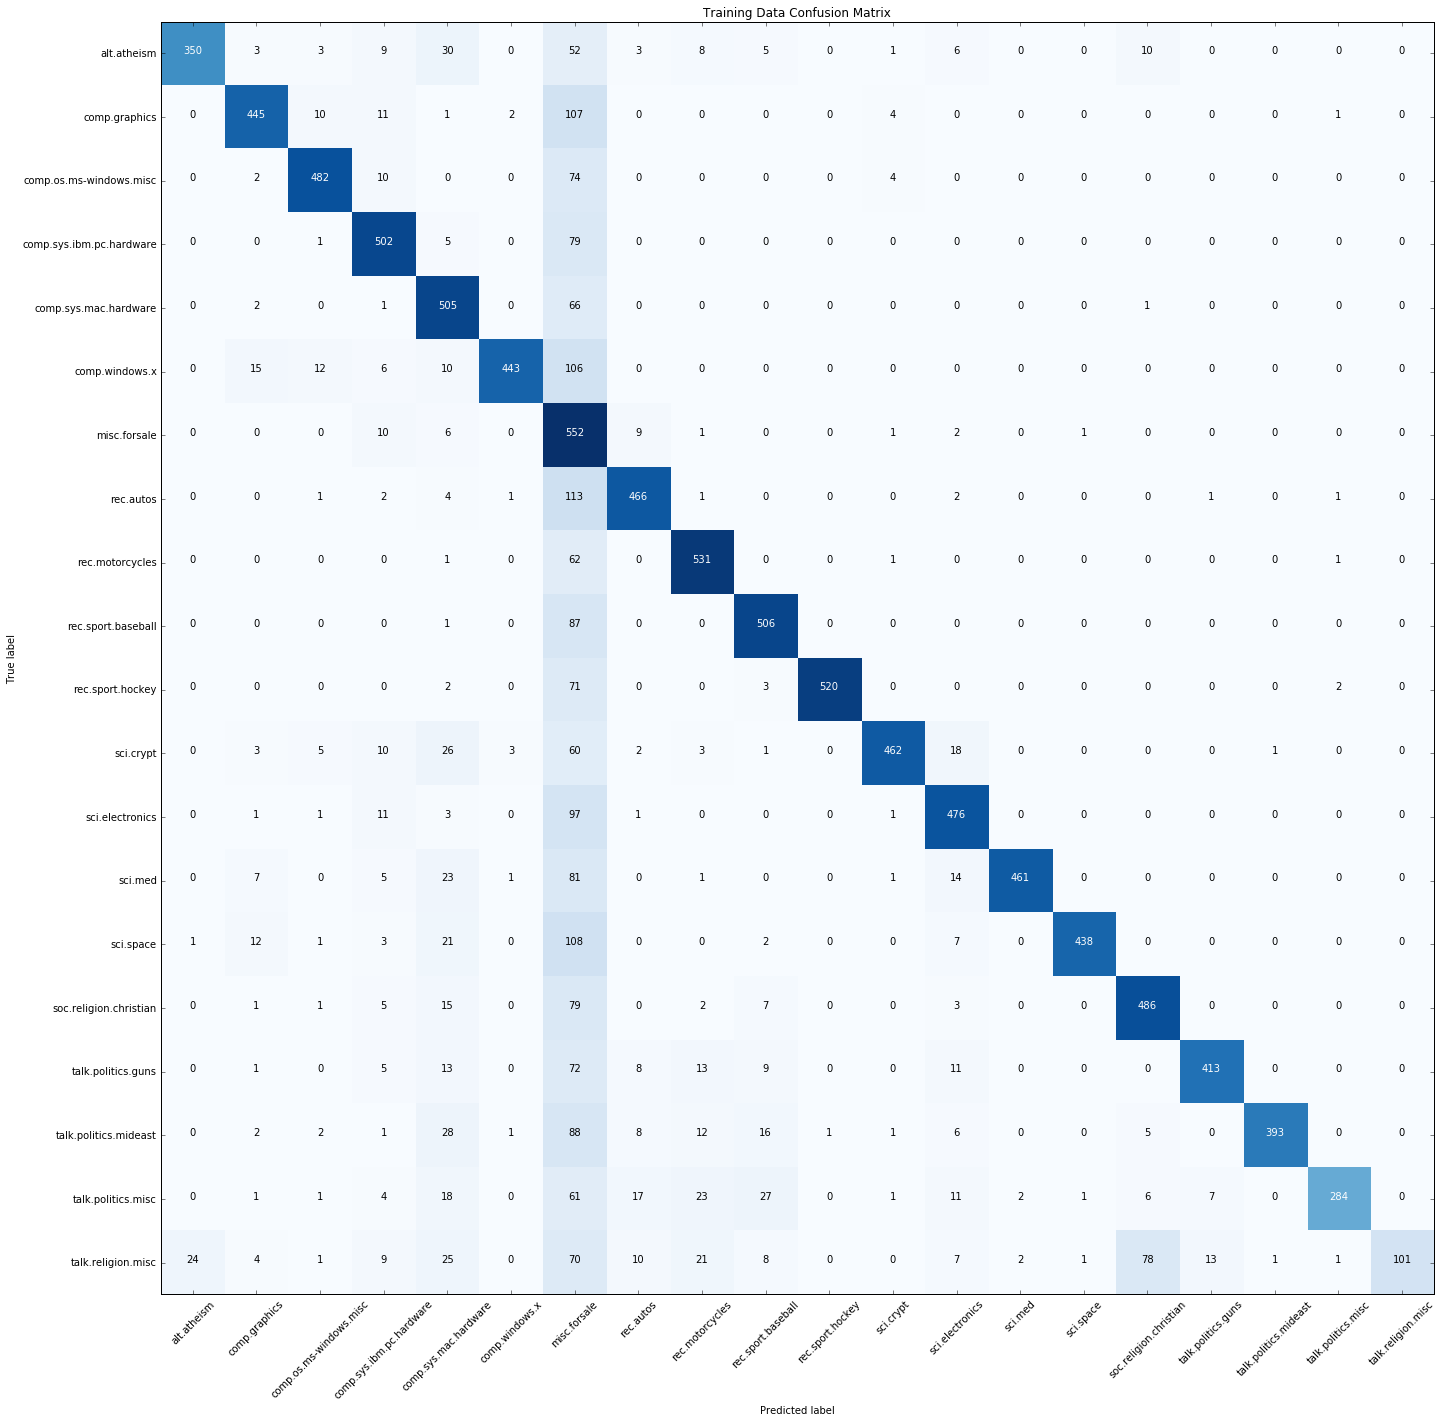

In [31]:
class_names_train = train_map['label_name'].values

# Compute confusion matrix
cnf_matrix_train = confusion_matrix(train_data_target, train_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (20,20))
plot_confusion_matrix(cnf_matrix_train, classes=class_names_train,
                      title='Training Data Confusion Matrix')

plt.show();

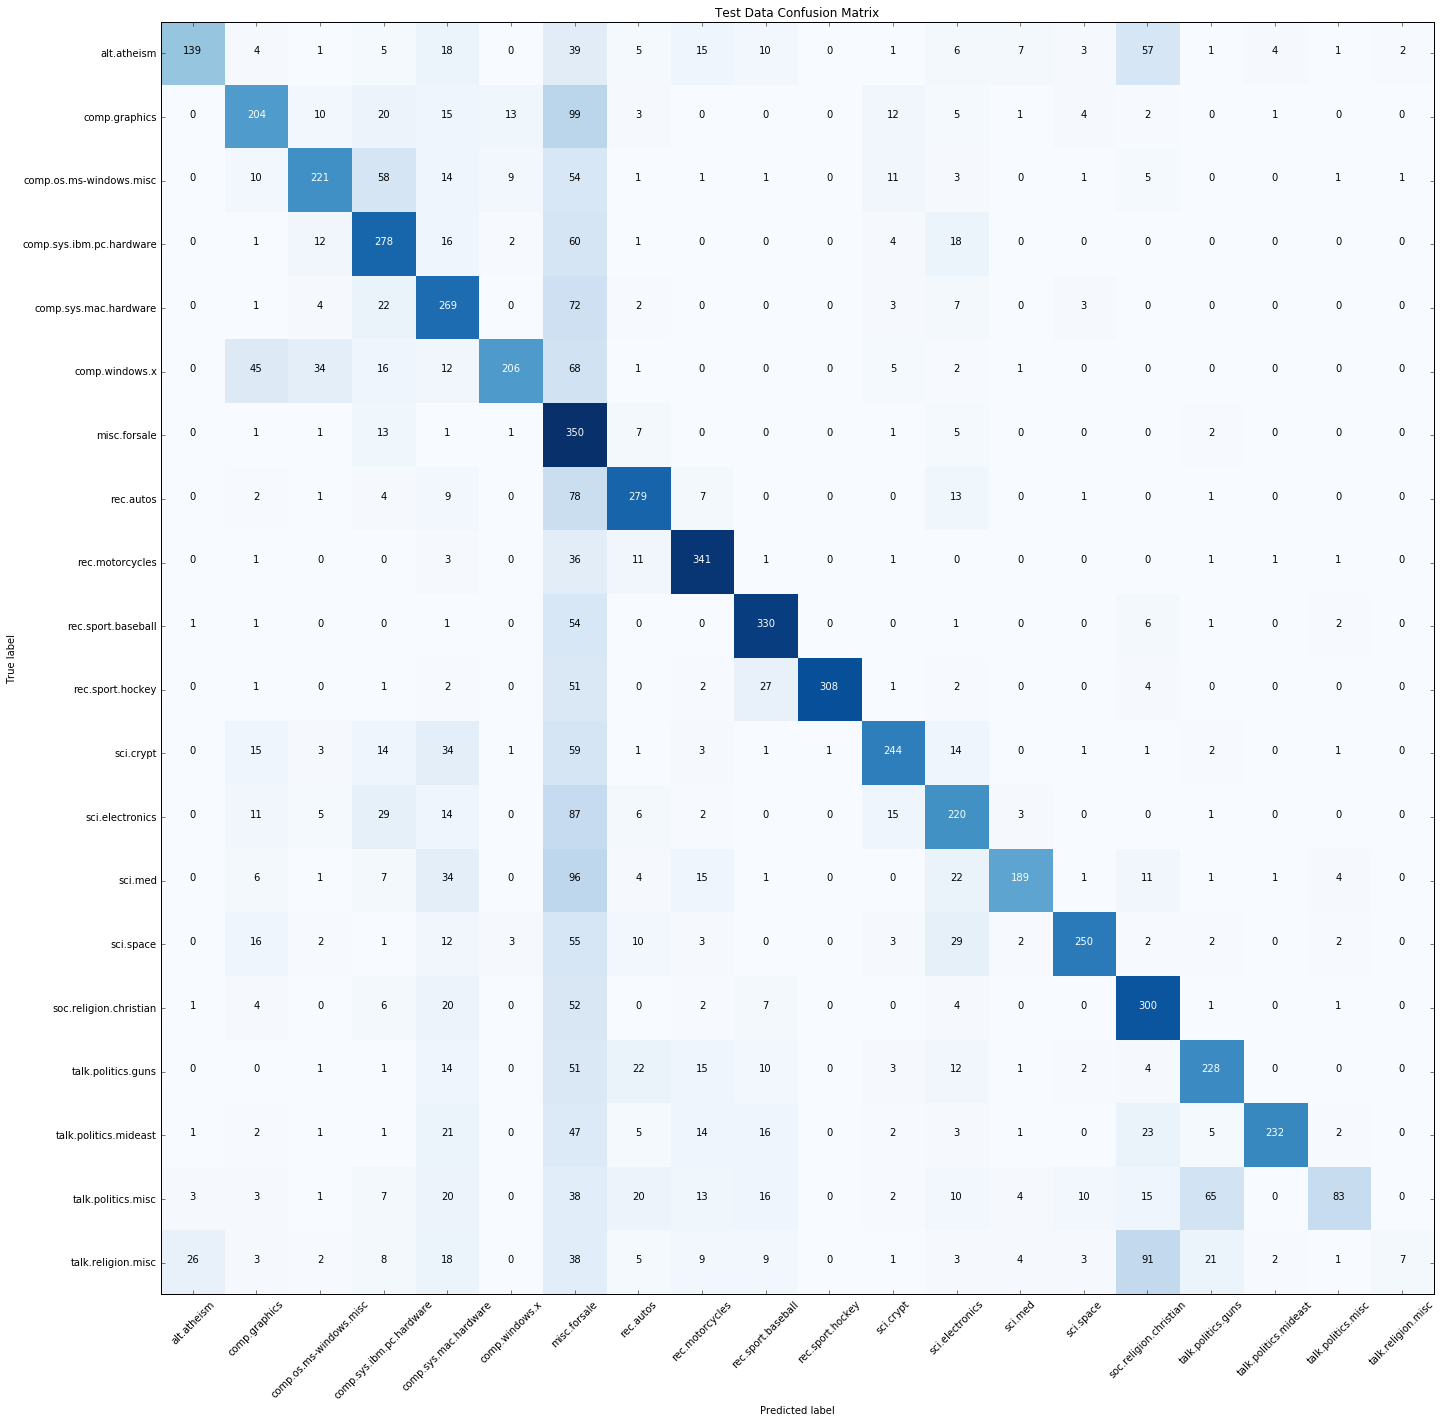

In [32]:
class_names_test = test_map['label_name'].values

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(test_data_target, test_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (20,20))
plot_confusion_matrix(cnf_matrix_test, classes=class_names_test,
                      title='Test Data Confusion Matrix')

plt.show();